## Environment Setup

In [42]:
# import relevant modules
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import imblearn
import sys
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, GRU, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import accuracy_score

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Settings
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=3)
sns.set(style="darkgrid")
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Data

In [4]:

# Dataset field names
datacols = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]

# Load NSL_KDD train dataset
dfkdd_train = pd.read_table("/content/drive/MyDrive/intrusion_dataset/KDDTrain+.txt", sep=",", names=datacols) # change path to where the dataset is located.
dfkdd_train = dfkdd_train.iloc[:,:-1] # removes an unwanted extra field

# Load NSL_KDD test dataset
dfkdd_test = pd.read_table("/content/drive/MyDrive/intrusion_dataset/KDDTest+.txt", sep=",", names=datacols)
dfkdd_test = dfkdd_test.iloc[:,:-1]

### Train dataset

In [5]:
# View train data
dfkdd_train.head(3)

# train set dimension
print('Train set dimension: {} rows, {} columns'.format(dfkdd_train.shape[0], dfkdd_train.shape[1]))

Train set dimension: 125973 rows, 42 columns


### Test dataset

In [6]:
# View test data
dfkdd_test.head(3)

# test set dimension
print('Test set dimension: {} rows, {} columns'.format(dfkdd_test.shape[0], dfkdd_test.shape[1]))

Test set dimension: 22544 rows, 42 columns


## Data Preprocessing

In [8]:
mapping = {'ipsweep': 'Probe','satan': 'Probe','nmap': 'Probe','portsweep': 'Probe','saint': 'Probe','mscan': 'Probe',
        'teardrop': 'DoS','pod': 'DoS','land': 'DoS','back': 'DoS','neptune': 'DoS','smurf': 'DoS','mailbomb': 'DoS',
        'udpstorm': 'DoS','apache2': 'DoS','processtable': 'DoS',
        'perl': 'U2R','loadmodule': 'U2R','rootkit': 'U2R','buffer_overflow': 'U2R','xterm': 'U2R','ps': 'U2R',
        'sqlattack': 'U2R','httptunnel': 'U2R',
        'ftp_write': 'R2L','phf': 'R2L','guess_passwd': 'R2L','warezmaster': 'R2L','warezclient': 'R2L','imap': 'R2L',
        'spy': 'R2L','multihop': 'R2L','named': 'R2L','snmpguess': 'R2L','worm': 'R2L','snmpgetattack': 'R2L',
        'xsnoop': 'R2L','xlock': 'R2L','sendmail': 'R2L',
        'normal': 'Normal'
        }

In [9]:
# Apply attack class mappings to the dataset
dfkdd_train['attack_class'] = dfkdd_train['attack'].apply(lambda v: mapping[v])
dfkdd_test['attack_class'] = dfkdd_test['attack'].apply(lambda v: mapping[v])

In [10]:
# Drop attack field from both train and test data
dfkdd_train.drop(['attack'], axis=1, inplace=True)
dfkdd_test.drop(['attack'], axis=1, inplace=True)

In [11]:
# View top 3 train data
dfkdd_train.head(3)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.0,150,25,0.17,0.03,0.17,0.0,0.0,0.0,0.05,0.0,Normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.0,255,1,0.00,0.60,0.88,0.0,0.0,0.0,0.00,0.0,Normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.0,255,26,0.10,0.05,0.00,0.0,1.0,1.0,0.00,0.0,DoS


### Exploratory Data Analysis

In [12]:
# Descriptive statistics
dfkdd_train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.0,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,0.001342,0.001103,0.302192,0.012669,0.000413,0.004096,0.0,0.000008,0.009423,84.107555,27.737888,0.284485,0.282485,0.119958,0.121183,0.660928,0.063053,0.097322,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,0.036603,0.045154,24.399618,0.483935,0.022181,0.099370,0.0,0.002817,0.096612,114.508607,72.635840,0.446456,0.447022,0.320436,0.323647,0.439623,0.180314,0.259830,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,143.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,1.000000,2.000000,7468.000000,43.000000,2.000000,9.000000,0.0,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
dfkdd_train['num_outbound_cmds'].value_counts()
dfkdd_test['num_outbound_cmds'].value_counts()

,count
num_outbound_cmds,
0,22544


In [14]:
# 'num_outbound_cmds' field has all 0 values. Hence, it will be removed from both train and test dataset since it is a redundant field.
dfkdd_train.drop(['num_outbound_cmds'], axis=1, inplace=True)
dfkdd_test.drop(['num_outbound_cmds'], axis=1, inplace=True)

In [15]:
# Attack Class Distribution
attack_class_freq_train = dfkdd_train[['attack_class']].apply(lambda x: x.value_counts())
attack_class_freq_test = dfkdd_test[['attack_class']].apply(lambda x: x.value_counts())
attack_class_freq_train['frequency_percent_train'] = round((100 * attack_class_freq_train / attack_class_freq_train.sum()),2)
attack_class_freq_test['frequency_percent_test'] = round((100 * attack_class_freq_test / attack_class_freq_test.sum()),2)

attack_class_dist = pd.concat([attack_class_freq_train,attack_class_freq_test], axis=1)
attack_class_dist

,attack_class,frequency_percent_train,attack_class,frequency_percent_test
attack_class,,,,
Normal,67343,53.46,9711,43.08
DoS,45927,36.46,7458,33.08
Probe,11656,9.25,2421,10.74
R2L,995,0.79,2754,12.22
U2R,52,0.04,200,0.89


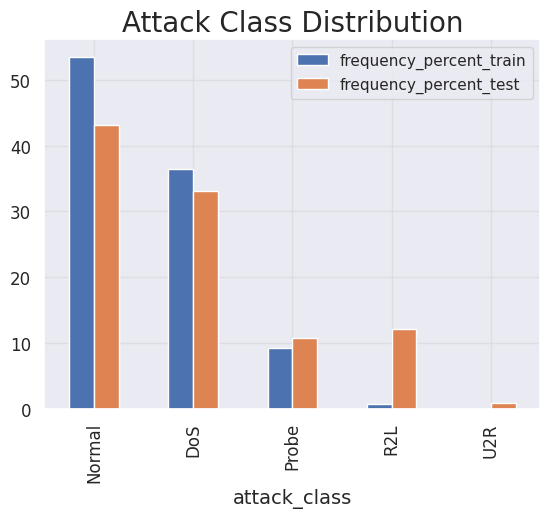

In [16]:
# Attack class bar plot
plot = attack_class_dist[['frequency_percent_train', 'frequency_percent_test']].plot(kind="bar");
plot.set_title("Attack Class Distribution", fontsize=20);
plot.grid(color='lightgray', alpha=0.5);

In [17]:
dfkdd_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,Normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,Normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,DoS
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,Normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Normal


### Scaling Numerical Attributes

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# extract numerical attributes and scale it to have zero mean and unit variance
cols = dfkdd_train.select_dtypes(include=['float64','int64']).columns
sc_train = scaler.fit_transform(dfkdd_train.select_dtypes(include=['float64','int64']))
sc_test = scaler.fit_transform(dfkdd_test.select_dtypes(include=['float64','int64']))

# turn the result back to a dataframe
sc_traindf = pd.DataFrame(sc_train, columns = cols)
sc_testdf = pd.DataFrame(sc_test, columns = cols)

### Encoding of Categorical Attributes

In [19]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

# extract categorical attributes from both training and test sets
cattrain = dfkdd_train.select_dtypes(include=['object']).copy()
cattest = dfkdd_test.select_dtypes(include=['object']).copy()

# encode the categorical attributes
traincat = cattrain.apply(encoder.fit_transform)
testcat = cattest.apply(encoder.fit_transform)

# separate target column from encoded data
enctrain = traincat.drop(['attack_class'], axis=1)
enctest = testcat.drop(['attack_class'], axis=1)

cat_Ytrain = traincat[['attack_class']].copy()
cat_Ytest = testcat[['attack_class']].copy()

### Data Sampling

In [20]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# define columns and extract encoded train set for sampling
sc_traindf = dfkdd_train.select_dtypes(include=['float64','int64'])
refclasscol = pd.concat([sc_traindf, enctrain], axis=1).columns
refclass = np.concatenate((sc_train, enctrain.values), axis=1)
X = refclass

# reshape target column to 1D array shape
c, r = cat_Ytest.values.shape
y_test = cat_Ytest.values.reshape(c,)

c, r = cat_Ytrain.values.shape
y = cat_Ytrain.values.reshape(c,)

# apply the random over-sampling
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({1: 67343, 0: 45927, 2: 11656, 3: 995, 4: 52})
Resampled dataset shape Counter({1: 67343, 0: 67343, 3: 67343, 2: 67343, 4: 67343})


### Feature Selection

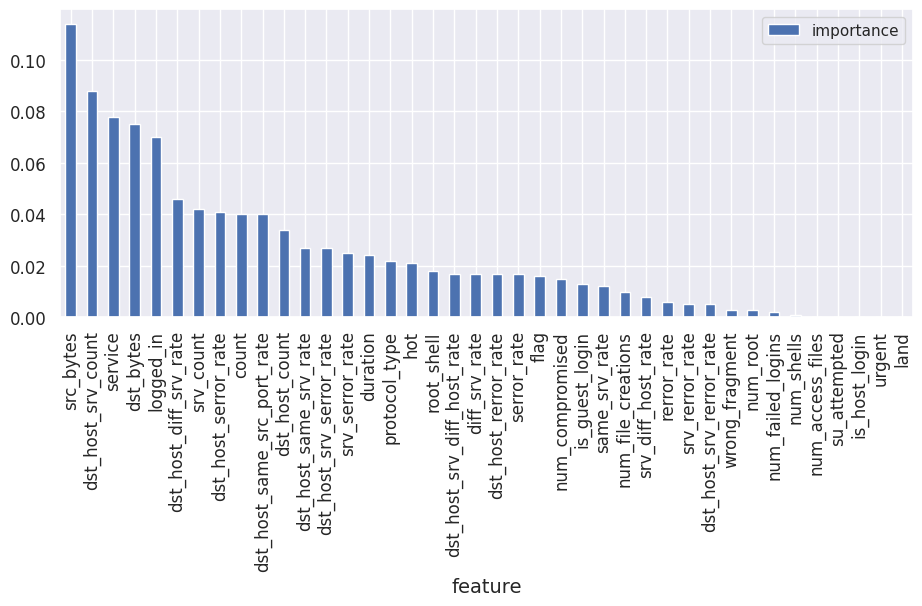

In [21]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier();

# fit random forest classifier on the training set
rfc.fit(X_res, y_res);
# extract important features
score = np.round(rfc.feature_importances_,3)
importances = pd.DataFrame({'feature':refclasscol,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
# plot importances
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar();

In [22]:
selected_features=["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate"]

### Dataset  Partition

In [23]:
# define columns to new dataframe
newcol = list(refclasscol)
newcol.append('attack_class')

# add a dimension to target
new_y_res = y_res[:, np.newaxis]

# create a dataframe from sampled data
res_arr = np.concatenate((X_res, new_y_res), axis=1)
res_df = pd.DataFrame(res_arr, columns = newcol)

# create test dataframe
reftest = pd.concat([sc_testdf, testcat], axis=1)
reftest['attack_class'] = reftest['attack_class'].astype(np.float64)
reftest['protocol_type'] = reftest['protocol_type'].astype(np.float64)
reftest['flag'] = reftest['flag'].astype(np.float64)
reftest['service'] = reftest['service'].astype(np.float64)

res_df.shape
reftest.shape

(22544, 41)

In [24]:
from collections import defaultdict
classdict = defaultdict(list)

# create two-target classes (normal class and an attack class)
attacklist = [('DoS', 0.0), ('Probe', 2.0), ('R2L', 3.0), ('U2R', 4.0)]
normalclass = [('Normal', 1.0)]

def create_classdict():
    '''This function subdivides train and test dataset into two-class attack labels'''
    for j, k in normalclass:
        for i, v in attacklist:
            restrain_set = res_df.loc[(res_df['attack_class'] == k) | (res_df['attack_class'] == v)]
            classdict[j +'_' + i].append(restrain_set)
            # test labels
            reftest_set = reftest.loc[(reftest['attack_class'] == k) | (reftest['attack_class'] == v)]
            classdict[j +'_' + i].append(reftest_set)

create_classdict()

In [25]:
for k, v in classdict.items():
    k

In [26]:
pretrain = classdict['Normal_DoS'][0]
pretest = classdict['Normal_DoS'][1]
grpclass = 'Normal_DoS'

### Finalize data preprocessing for training

In [27]:
from sklearn.preprocessing import OneHotEncoder
#enc = OneHotEncoder()
enc = OneHotEncoder( handle_unknown='ignore')

Xresdf = pretrain
newtest = pretest

Xresdfnew = Xresdf[selected_features]
Xresdfnum = Xresdfnew.drop(['service'], axis=1)
Xresdfcat = Xresdfnew[['service']].copy()

Xtest_features = newtest[selected_features]
Xtestdfnum = Xtest_features.drop(['service'], axis=1)
Xtestcat = Xtest_features[['service']].copy()


# Fit train data
enc.fit(Xresdfcat)
enc.categories_
# Transform train data
X_train_1hotenc = enc.transform(Xresdfcat).toarray()

# Transform test data
X_test_1hotenc = enc.transform(Xtestcat).toarray()

X_train = np.concatenate((Xresdfnum.values, X_train_1hotenc), axis=1)
X_test = np.concatenate((Xtestdfnum.values, X_test_1hotenc), axis=1)

y_train = Xresdf[['attack_class']].copy()
c, r = y_train.values.shape
Y_train = y_train.values.reshape(c,)

y_test = newtest[['attack_class']].copy()
c, r = y_test.values.shape
Y_test = y_test.values.reshape(c,)


## Train Models

In [33]:
# Define shape of the input
n_features = X_train.shape[1]

# Reshape input data for GRU model
X_train_gru = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_gru = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define a Bi-directional GRU model
model = Sequential()
model.add(Bidirectional(GRU(64, return_sequences=True), input_shape=(1, n_features)))
model.add(Bidirectional(GRU(32)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model architecture
model.summary()


# Train the model
model.fit(X_train_gru, Y_train, epochs=10, batch_size=64, verbose=1)

# Evaluate the model
train_predictions = model.predict(X_train_gru)
test_predictions = model.predict(X_test_gru)

# Binarize output for accuracy calculation
train_predictions_binarized = (train_predictions > 0.5).astype(int)
test_predictions_binarized = (test_predictions > 0.5).astype(int)

train_accuracy = accuracy_score(Y_train, train_predictions_binarized)
test_accuracy = accuracy_score(Y_test, test_predictions_binarized)

print(f"Training Accuracy: {train_accuracy*100:.2f}%")
print(f"Testing Accuracy: {test_accuracy*100:.2f}%")

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_9 (Bidirectional)      │ (None, 1, 128)              │          65,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ (None, 64)                  │          31,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 96,449 (376.75 KB)

 Trainable params: 96,449 (376.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 44s 9ms/step - accuracy: 0.9901 - loss: 0.0467
Epoch 2/10
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.9987 - loss: 0.0044
Epoch 3/10
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9989 - loss: 0.0036
Epoch 4/10
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.9989 - loss: 0.0031
Epoch 5/10
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.9991 - loss: 0.0026
Epoch 6/10
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9993 - loss: 0.0020
Epoch 7/10
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.9994 - loss: 0.0020
Epoch 8/10
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9994 - loss: 0.0019
Epoch 9/10
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9995 - loss: 0.0017
Epoch 10/10
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9993 - loss: 0.0021
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step
537/537 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training Accuracy: 99.9

In [31]:
# Define shape of the input
n_features = X_train.shape[1]

# Reshape input data for GRU model
X_train_gru = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_gru = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define a more complex Bi-directional GRU model
model = Sequential()
model.add(Bidirectional(GRU(128, return_sequences=True), input_shape=(1, n_features)))
model.add(Bidirectional(GRU(64, return_sequences=True)))
model.add(Bidirectional(GRU(32)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model architecture
model.summary()

# Train the model
model.fit(X_train_gru, Y_train, epochs=10, batch_size=64, verbose=1)

# Evaluate the model
train_predictions = model.predict(X_train_gru)
test_predictions = model.predict(X_test_gru)

# Binarize output for accuracy calculation
train_predictions_binarized = (train_predictions > 0.5).astype(int)
test_predictions_binarized = (test_predictions > 0.5).astype(int)

train_accuracy = accuracy_score(Y_train, train_predictions_binarized)
test_accuracy = accuracy_score(Y_test, test_predictions_binarized)

print(f"Training Accuracy: {train_accuracy*100:.2f}%")
print(f"Testing Accuracy: {test_accuracy*100:.2f}%")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional)      │ (None, 1, 256)              │         179,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 1, 128)              │         123,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 64)                  │          31,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 335,521 (1.28 MB)

 Trainable params: 335,521 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 55s 19ms/step - accuracy: 0.9885 - loss: 0.0487
Epoch 2/10
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.9981 - loss: 0.0056
Epoch 3/10
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 38s 17ms/step - accuracy: 0.9988 - loss: 0.0040
Epoch 4/10
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.9988 - loss: 0.0033
Epoch 5/10
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 39s 18ms/step - accuracy: 0.9991 - loss: 0.0030
Epoch 6/10
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 39s 17ms/step - accuracy: 0.9993 - loss: 0.0023
Epoch 7/10
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 45s 19ms/step - accuracy: 0.9990 - loss: 0.0024
Epoch 8/10
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 39s 18ms/step - accuracy: 0.9993 - loss: 0.0028
Epoch 9/10
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 37s 18ms/step - accuracy: 0.9993 - loss: 0.0023
Epoch 10/10
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 43s 19ms/step - accuracy: 0.9993 - loss: 0.0021
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step
537/537 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Training Accur

In [36]:
# Define shape of the input
n_features = X_train.shape[1]

# Reshape input data for GRU model
X_train_gru = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_gru = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define an even more complex Bi-directional GRU model
model = Sequential()
model.add(Bidirectional(GRU(128, return_sequences=True), input_shape=(1, n_features)))
model.add(Dropout(0.2))
model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(GRU(64, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(GRU(32)))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model architecture
model.summary()

# Train the model
model.fit(X_train_gru, Y_train, epochs=10, batch_size=64, verbose=1)

# Evaluate the model
train_predictions = model.predict(X_train_gru)
test_predictions = model.predict(X_test_gru)

# Binarize output for accuracy calculation
train_predictions_binarized = (train_predictions > 0.5).astype(int)
test_predictions_binarized = (test_predictions > 0.5).astype(int)

train_accuracy = accuracy_score(Y_train, train_predictions_binarized)
test_accuracy = accuracy_score(Y_test, test_predictions_binarized)

print(f"Training Accuracy: {train_accuracy*100:.2f}%")
print(f"Testing Accuracy: {test_accuracy*100:.2f}%")

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_12 (Bidirectional)     │ (None, 1, 256)              │         179,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_13 (Bidirectional)     │ (None, 1, 256)              │         296,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_14 (Bidirectional)     │ (None, 1, 128)              │         123,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_15 (Bidirectional)     │ (None, 64)                  │          31,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 633,537 (2.42 MB)

 Trainable params: 633,537 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 84s 32ms/step - accuracy: 0.9869 - loss: 0.0551
Epoch 2/10
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 67s 32ms/step - accuracy: 0.9979 - loss: 0.0070
Epoch 3/10
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 82s 32ms/step - accuracy: 0.9986 - loss: 0.0046
Epoch 4/10
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 81s 32ms/step - accuracy: 0.9987 - loss: 0.0045
Epoch 5/10
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 81s 31ms/step - accuracy: 0.9989 - loss: 0.0038
Epoch 6/10
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 70s 33ms/step - accuracy: 0.9988 - loss: 0.0034
Epoch 7/10
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 64s 30ms/step - accuracy: 0.9993 - loss: 0.0026
Epoch 8/10
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 85s 32ms/step - accuracy: 0.9993 - loss: 0.0024
Epoch 9/10
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 79s 31ms/step - accuracy: 0.9991 - loss: 0.0027
Epoch 10/10
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 86s 33ms/step - accuracy: 0.9990 - loss: 0.0033
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step
537/537 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
Training Accur

In [43]:
# Define shape of the input
n_features = X_train.shape[1]

# Reshape input data for GRU model
X_train_gru = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_gru = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define an enhanced Bi-directional GRU model with additional techniques
model = Sequential()
model.add(Bidirectional(GRU(128, return_sequences=True, kernel_regularizer=l2(0.01)), input_shape=(1, n_features)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Bidirectional(GRU(128, return_sequences=True, kernel_regularizer=l2(0.01))))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Bidirectional(GRU(64, kernel_regularizer=l2(0.01))))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model architecture
model.summary()

# Learning rate scheduler to reduce learning rate when a metric has stopped improving
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.00001)

# Train the model with learning rate scheduler
model.fit(X_train_gru, Y_train, epochs=20, batch_size=64, verbose=1, validation_split=0.2, callbacks=[lr_reduction])

# Evaluate the model
train_predictions = model.predict(X_train_gru)
test_predictions = model.predict(X_test_gru)

# Binarize output for accuracy calculation
train_predictions_binarized = (train_predictions > 0.5).astype(int)
test_predictions_binarized = (test_predictions > 0.5).astype(int)

train_accuracy = accuracy_score(Y_train, train_predictions_binarized)
test_accuracy = accuracy_score(Y_test, test_predictions_binarized)

print(f"Training Accuracy: {train_accuracy*100:.2f}%")
print(f"Testing Accuracy: {test_accuracy*100:.2f}%")

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_20 (Bidirectional)     │ (None, 1, 256)              │         179,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_21 (Bidirectional)     │ (None, 1, 256)              │         296,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 1, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_22 (Bidirectional)     │ (None, 128)                 │         123,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 606,529 (2.31 MB)

 Trainable params: 605,505 (2.31 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/20
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 87s 43ms/step - accuracy: 0.9793 - loss: 1.6101 - val_accuracy: 0.9973 - val_loss: 0.0822 - learning_rate: 0.0010
Epoch 2/20
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 55s 33ms/step - accuracy: 0.9922 - loss: 0.0908 - val_accuracy: 0.9981 - val_loss: 0.0633 - learning_rate: 0.0010
Epoch 3/20
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 58s 34ms/step - accuracy: 0.9931 - loss: 0.0794 - val_accuracy: 0.9957 - val_loss: 0.0557 - learning_rate: 0.0010
Epoch 4/20
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 55s 33ms/step - accuracy: 0.9927 - loss: 0.0670 - val_accuracy: 0.9993 - val_loss: 0.0388 - learning_rate: 0.0010
Epoch 5/20
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 82s 33ms/step - accuracy: 0.9937 - loss: 0.0594 - val_accuracy: 0.9982 - val_loss: 0.0447 - learning_rate: 0.0010
Epoch 6/20
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 85s 34ms/step - accuracy: 0.9943 - loss: 0.0561 - val_accuracy: 0.9814 - val_loss: 0.0640 - learning_rate: 0.0010
Epoch 7/20
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 59s 35ms/step - accura

## Evaluate Models

## Test Models